## Example - Ptychography

In this example, we'll modify the BCDI setup so that instead of collecting and reconstructing one image, many diffraction patterns are collected over the sample area. Each sample image overlaps with the previous one, providing redundant information which aids the phase reconstruction and allows the imaging field to be scaled arbitrarily large - limited by stage movement, sample durability, and other physical factors rather than the available size of an optical lens. 

The process of collecting overlapping images can be done in several ways - the simplest is to step-and-repeat the collection of images over a pre-defined area, then do the post-processing offline. However, with large samples and/or small regions of interest, this may not be the most effective way to image. More advanced setups can be done in a "streaming" way, where the reconstructed real-space image is updated each step of the way and the process can be controlled with human feedback. To increase speed further, human feedback can be replaced with automated feature detection and search strategies. 

We'll start by looking at the simplest setup: offline processing.

In [1]:
import networkx as nx
import sys
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import namedtuple
from copy import deepcopy
from functools import reduce
from typing import Callable, Any
from itertools import accumulate

In [2]:
from systemflow.node import *
from systemflow.mutations import *
from systemflow.metrics import *
from systemflow.auxtypes import is_proportion
from systemflow.xrs import *

The basic setup for ptychography is the same as BCDI - a sample stage, far-field diffraction pattern sensor, and analysis computer. However, this time instead of taking and analyzing one image, we'll be taking a series of images collected from different sample positions.

The most basic strategy we can take is to acquire an image, step to the next position, and continue until the entire sample has been imaged. We'll define two execution graphs: acquiring an image, and the end-stage processing.

In [3]:
sample_stage_mutations = [PositionSample(),]
vc_sample = collect_parameters(sample_stage_mutations)

sample_stage = Component("Sample Stage",
                    sample_stage_mutations,
                    {vc_sample.last_position: [0.0, 0.0],
                     vc_sample.position: [0.0, 0.0],
                     vc_sample.move_rate: 100,
                     vc_sample.settle_time: 1e-3,},
                     {})

In [4]:
detector_mutations = [CollectImage(),]
vc_detector = collect_parameters(detector_mutations)

detector_host = Component("Image sensor",
                    detector_mutations,
                    parameters = {vc_detector.resolution: (2000, 2000),
                     vc_detector.bitdepth: 16,
                     vc_detector.readout: 1e-3,
                     vc_detector.pixelenergy: 1e-3,
                     vc_detector.sample_rate: 10e3,})

In [5]:
cpu_mutations = [StoreImage(),]
vc_storage = collect_parameters(cpu_mutations)

cpu_host = Component("CPU host",
                     cpu_mutations,
                     parameters={
                     vc_storage.storage_rate: 1e9,
                     vc_storage.stored_images: 0,
                     vc_storage.stored_data: 0,})

In [6]:
sampling_nodes = [sample_stage, detector_host, cpu_host]
sampling_links = [DefaultLink("Sample Stage -> Image sensor",
                              sample_stage.name,
                              detector_host.name),
                    DefaultLink("Image sensor -> CPU host",
                                detector_host.name,
                                cpu_host.name),]

sampling_metrics = [TotalLatency(),]

sampling_exg = ExecutionGraph(name="Sampling Process",
                              nodes=sampling_nodes,
                              links=sampling_links,
                              metrics=sampling_metrics)

In [7]:
# step through 1 iteration of collecting an image so we can examine the output
sampling_exg_2 = sampling_exg()

In [8]:
msg1 = sampling_exg_2.get_output_msg()

In [9]:
msg1.fields

{'relevancy (%)': 1.0,
 'image data (B)': np.float64(8000000.0),
 'readout latency (s)': 0.001,
 'movement latency (s)': np.float64(0.001),
 'position (mm,mm)': [0.0, 0.0],
 'stored data (B)': np.float64(8000000.0)}

In [10]:
msg1.properties

{'resolution (n,n)': (2000, 2000),
 'images (n)': 1,
 'sample rate (Hz)': 10000.0,
 'bitdepth (n)': 16,
 'stored images (n)': 1}

In [11]:
sampling_exg_2.nodes

In [12]:
sampling_exg_2.nodes[0].properties

{'storage latency (s)': np.float64(0.008)}

In [13]:
sampling_exg_2.nodes[0].parameters

{'disk storage rate (B/s)': 1000000000.0,
 'stored images (n)': 0,
 'stored data (B)': 0}

In [14]:
pdict = match_message_to_parameters(sampling_exg_2, vc_storage, cpu_host.name)

In [15]:
pdict

{'CPU host': {'stored data (B)': np.float64(8000000.0),
  'stored images (n)': 1}}

In [16]:
sampling_exg_2a = sampling_exg_2.with_updated_parameters(pdict)

In [17]:
sampling_exg_2a.nodes[0].parameters

{'disk storage rate (B/s)': 1000000000.0,
 'stored images (n)': 1,
 'stored data (B)': np.float64(8000000.0)}

In [18]:
sampling_exg_2a.nodes[0].parameters["stored images (n)"]

1

In [19]:
sampling_exg_3 = sampling_exg_2a()

In [20]:
sampling_exg_3.get_output_msg().properties

{'resolution (n,n)': (2000, 2000),
 'images (n)': 1,
 'sample rate (Hz)': 10000.0,
 'bitdepth (n)': 16,
 'stored images (n)': 2}

In [21]:
def serpentine_points(rect_limits, n_steps):
    """
    Generate a list of (x, y) points in a serpentine pattern over a rectangle.

    Parameters:
        rect_limits (tuple): (limit_x, limit_y) - dimensions of the rectangle.
        n_steps (tuple): (n_x, n_y) - number of steps in x and y directions.

    Returns:
        points (list): List of (x, y) tuples following the serpentine curve.
    """
    limit_x, limit_y = rect_limits
    n_x, n_y = n_steps

    x_vals = np.linspace(0, limit_x, n_x)
    y_vals = np.linspace(0, limit_y, n_y)

    points = []
    for j, y in enumerate(y_vals):
        if j % 2 == 0:
            # left to right
            for x in x_vals:
                points.append((x, y))
        else:
            # right to left
            for x in reversed(x_vals):
                points.append((x, y))
    return np.array(points)

In [22]:
pts = serpentine_points((20.0, 20.0), (20, 20))

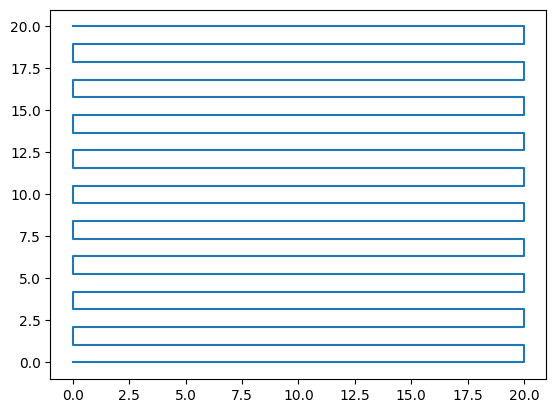

In [23]:
plt.plot(pts[:,0], pts[:,1])

In [24]:
pts.shape

(400, 2)

In [25]:
sampling_exg

In [26]:
sampling_exg.get_all_node_parameters()

{'Sample Stage': {'last position (mm,mm)': [0.0, 0.0],
  'position (mm,mm)': [0.0, 0.0],
  'move rate (mm/s)': 100,
  'settle time (s)': 0.001},
 'Image sensor': {'resolution (n,n)': (2000, 2000),
  'bit depth (n)': 16,
  'readout latency (s)': 0.001,
  'pixel energy (J)': 0.001,
  'sample rate (Hz)': 10000.0},
 'CPU host': {'disk storage rate (B/s)': 1000000000.0,
  'stored images (n)': 0,
  'stored data (B)': 0}}

In [27]:
sampling_exg.get_output_msg()

In [28]:
sampling_exg_2.get_all_node_parameters()

{'CPU host': {'disk storage rate (B/s)': 1000000000.0,
  'stored images (n)': 0,
  'stored data (B)': 0},
 'Image sensor': {'resolution (n,n)': (2000, 2000),
  'bit depth (n)': 16,
  'readout latency (s)': 0.001,
  'pixel energy (J)': 0.001,
  'sample rate (Hz)': 10000.0},
 'Sample Stage': {'last position (mm,mm)': [0.0, 0.0],
  'position (mm,mm)': [0.0, 0.0],
  'move rate (mm/s)': 100,
  'settle time (s)': 0.001}}

In [29]:
sampling_exg_2.get_output_msg()

Message(fields={'relevancy (%)': 1.0, 'image data (B)': np.float64(8000000.0), 'readout latency (s)': 0.001, 'movement latency (s)': np.float64(0.001), 'position (mm,mm)': [0.0, 0.0], 'stored data (B)': np.float64(8000000.0)}, properties={'resolution (n,n)': (2000, 2000), 'images (n)': 1, 'sample rate (Hz)': 10000.0, 'bitdepth (n)': 16, 'stored images (n)': 1})

In [30]:
sample_stage.name

'Sample Stage'

In [31]:
vc_sample

VarCollection(
    position='position (mm,mm)',
    last_position='last position (mm,mm)',
    move_rate='move rate (mm/s)',
    settle_time='settle time (s)'
)

In [32]:
match_message_to_parameters(sampling_exg_2, vc_sample)

{'position (mm,mm)': [0.0, 0.0]}

In [33]:
sampling_exg_2.get_output_msg().fields

{'relevancy (%)': 1.0,
 'image data (B)': np.float64(8000000.0),
 'readout latency (s)': 0.001,
 'movement latency (s)': np.float64(0.001),
 'position (mm,mm)': [0.0, 0.0],
 'stored data (B)': np.float64(8000000.0)}

In [34]:
vc_sample.last_position

'last position (mm,mm)'

In [35]:
sampling_exg.name

'Sampling Process'

In [36]:
analysis_mutations = [InputMessage(), PhaseReconstruction3D(),]
vc_analysis = collect_parameters(analysis_mutations)
analysis_host = Component("Offline analysis",
                          analysis_mutations,
                          {vc_analysis.op_latency: 1e-5,
                           vc_analysis.parallelism: 0.70,
                           vc_analysis.overlap: 0.40,
                           vc_analysis.iterations: 20,
                           vc_analysis.xy_images: (20, 20),
                           vc_analysis.input_message: sampling_exg_2.get_output_msg(),})


In [37]:
analysis_exg = ExecutionGraph("Offline reconstruction",
                              [analysis_host,],
                              links = [],
                              metrics = [])

In [53]:
class OfflinePtychographySystem(System):
    def __init__(self, sample_limits: tuple, n_steps: tuple):
        super().__init__("Offline Ptychography", 
                         {sampling_exg.name: sampling_exg,
                          analysis_exg.name: analysis_exg,},
                         )
        self.sample_limits = sample_limits
        self.n_steps = n_steps
        #initialize the first step
        self.execution_history.append(sampling_exg())

    def step(self, new_position):
        previous_graph = self.execution_history[-1]
        #find out where the previous sample position was
        previous_position = previous_graph.get_output_msg().fields[vc_sample.position]
        #find how many images & how much data were stored in the graph its last call
        new_cpu_params = match_message_to_parameters(previous_graph, vc_storage, cpu_host.name)
        new_sample_params = {sample_stage.name: {vc_sample.last_position: previous_position,
                                                    vc_sample.position: new_position,}}
        
        new_params = new_cpu_params | new_sample_params
        
        new_graph = previous_graph.with_updated_parameters(new_params)()
        return new_graph

    def flow_control(self):
        sample_points = serpentine_points(self.sample_limits, self.n_steps)

        #collect and store the diffraction imaging data
        for point in sample_points:
            new_graph = self.step(point)
            self.execution_history.append(new_graph)

        #then run the reconstruction
        analysis_graph = self.exec_graphs[analysis_exg.name]
        #find the number of stored images
        final_msg = self.execution_history[-1].get_output_msg()
        analysis_graph = analysis_graph.with_updated_parameters(
            {analysis_exg.nodes[0].name: {vc_analysis.input_message: final_msg,
                                          vc_analysis.xy_images: self.n_steps}})
        
        self.execution_history.append(analysis_graph())

        return self.execution_history


In [54]:
optych = OfflinePtychographySystem((20.0, 20.0), (20, 20))

In [55]:
optych_2 = optych()

In [56]:
final_msg = optych_2.execution_history[-1].get_output_msg()

In [57]:
final_msg

Message(fields={'relevancy (%)': 1.0, 'image data (B)': np.float64(8000000.0), 'readout latency (s)': 0.001, 'movement latency (s)': np.float64(0.011526315789473683), 'position (mm,mm)': array([ 0., 20.]), 'stored data (B)': np.float64(3208000000.0), 'reconstruction (B)': 64731679.36000001, 'phase data (B)': 25600000000}, properties={'resolution (n,n)': (2000, 2000), 'images (n)': 1, 'sample rate (Hz)': 10000.0, 'bitdepth (n)': 16, 'stored images (n)': 401, 'phase reconstruction (n,n)': (2011.4, 2011.4), 'phase reconstruction latency (s)': np.float64(0.02605099894164507)})

In [43]:
analysis_host.parameters[vc_analysis.overlap]

0.4

In [44]:
analysis_exg()

In [45]:
analysis_g2 = analysis_exg.with_updated_parameters({analysis_exg.nodes[0].name: {vc_analysis.input_message: final_msg,}})()

In [47]:
analysis_g2.get_output_msg()

Message(fields={'relevancy (%)': 1.0, 'image data (B)': np.float64(8000000.0), 'readout latency (s)': 0.001, 'movement latency (s)': np.float64(0.011526315789473683), 'position (mm,mm)': array([ 0., 20.]), 'stored data (B)': np.float64(3208000000.0), 'reconstruction (B)': 64731679.36000001, 'phase data (B)': 25600000000}, properties={'resolution (n,n)': (2000, 2000), 'images (n)': 1, 'sample rate (Hz)': 10000.0, 'bitdepth (n)': 16, 'stored images (n)': 401, 'phase reconstruction (n,n)': (2011.4, 2011.4), 'phase reconstruction latency (s)': np.float64(0.02605099894164507)})

We've now setup the components necessary to collect an image which will become part of the reconstruction. However, this collection becomes a multi-step process which we must model. We do this by incorporating a new element, a System which controls the flow of different execution graphs:

In [ ]:
class OfflinePtychography(System):
    def __init__(self, name, x_steps: int = 20, y_steps: int = 20, iter = 0, execution_history = ...):
        exec_graphs = {"sampling": sampling_exg,
                        "storage": storage_exg,
                        "analysis": analysis_exg,}
        super().__init__(name, exec_graphs, iter, execution_history)
        self.x_steps = x_steps
        self.y_steps = y_steps

    def flow_control(self):

        

In [23]:
# pickup - get control flow through System

In [ ]:
cpu_mutations = [FlatFieldCorrection(),
                MaskCorrection(),
                PhaseReconstruction3D(),]

vc_cpu = collect_parameters(cpu_mutations)

In [ ]:
cpu_host = Component("Processor",
                    cpu_mutations,
                    parameters = {vc_cpu.op_latency: 1e-6,
                                  vc_cpu.parallelism: 0.75,
                                  vc_cpu.kernel_size: (0.02, 0.02),
                                  vc_cpu.mask_proportion: 0.05,
                                  vc_cpu.op_latency: 1e-7,
                                  vc_cpu.iterations: 20,
                                  vc_cpu.overlap: 0.40,})

In [20]:
cpu_host2 = cpu_host()

TypeError: Component.__call__() missing 1 required positional argument: 'exg'

In [11]:
ci_host = Component("Image sensor",
                    [CollectImage(),],
                    parameters = {vc_img.resolution: (2000, 2000),
                     vc_img.bitdepth: 16,
                     vc_img.readout: 1e-3,
                     vc_img.pixelenergy: 1e-3,
                     vc_img.sample_rate: 10e3,})

In [ ]:
nodes = [sample_stage, ci_host, cpu_host]

In [ ]:
links = [DefaultLink("Sample Stage -> Image sensor",
                     "Sample Stage",
                     "Image sensor"),
        DefaultLink("Image sensor -> Processor",
                     "Image sensor",
                     "Processor"),]

We'll also define metrics that look at the main host properties predicted by the ExecutionGraph which we want to measure:

In [37]:
class ReconstructionPower(Metric):
    def __init__(self):
        super().__init__("Phase reconstruction power", 
                         [],
                         [PhaseReconstruction2D().outputs.host_properties.ops],)
        
    def metric(self, message: Message, properties: dict):
        matches = self.graph_matches(properties)
        power = np.prod(matches[0]) * 1e-8
        metrics = {"reconstruction power (W)": power,}
        
        return metrics
    

In [38]:
class TotalOps(Metric):
    def __init__(self):
        super().__init__("Total operations", 
                         [],
                         [Regex(r"ops \(n,n\)"),],)
        
    def metric(self, message: Message, properties: dict):
        matches = self.graph_matches(properties)
        ops = np.sum([np.prod(op) for op in matches])
        metrics = {"total ops (n)": ops,}
        
        return metrics
    

In [39]:
class TotalLatency(Metric):
    def __init__(self):
        super().__init__("Total latency", 
                         [Regex(r"latency \(s\)"),],
                         [],)
        
    def metric(self, message: Message, properties: dict):
        matches = self.message_matches(message)
        ops = np.sum(matches)
        metrics = {"total latency (s)": ops,}
        
        return metrics
    

In [40]:
bcdi_graph = ExecutionGraph("BCDI Experiment", nodes, links, [ReconstructionPower(), TotalOps(), TotalLatency()])

In [41]:
g2 = bcdi_graph()

In [42]:
g2

In [43]:
g2.metric_values

{'reconstruction power (W)': np.float64(6.08164799306237),
 'total ops (n)': np.float64(612164799.306237),
 'total latency (s)': np.float64(0.0020335507624599796)}

In [44]:
g2.get_all_node_parameters()

{'Processor': {'op latency (s)': 1e-07,
  'parallelism (%)': 0.75,
  'kernel size (%,%)': (0.02, 0.02),
  'masking proportion (%)': 0.05,
  'iterations (n)': 20},
 'Image sensor': {'resolution (n,n)': (2000, 2000),
  'bit depth (n)': 16,
  'readout latency (s)': 0.001,
  'pixel energy (J)': 0.001,
  'sample rate (Hz)': 10000.0},
 'Sample Stage': {'position (mm,mm)': [0.0, 0.0],
  'last position (mm,mm)': [0.0, 0.0],
  'move rate (mm/s)': 100,
  'settle time (s)': 0.001}}

And we'll setup one experiment to sweep over the sensor resolution:

In [45]:
def sweep_resolution(resolution: tuple, exg: ExecutionGraph):
    # an empirical relationship we assume between the classifier skill and number of filters
    new_params = {"Image sensor": {vc_img.resolution: resolution,}}
    # we can simply call an existing graph with new parameters
    new_exg = exg.with_updated_parameters(new_params)()

    power = new_exg.metric_values["reconstruction power (W)"]
    ops = new_exg.metric_values["total ops (n)"]
    latency = new_exg.metric_values["total latency (s)"]
    return power, ops, latency

In [46]:
# assume aspect ratio stays the same and scales up and down
resolutions = [np.astype(s * np.array((2000, 1400)), 'int') for s in np.linspace(start=0.8, stop=6.0, num=101)]
megapixels = [np.prod(r)/1e6 for r in resolutions]

In [47]:
metrics = [sweep_resolution(r, g2) for r in resolutions]

In [48]:
import plotly.graph_objects as go

Now, we can predict the overall power and latency for a single image by number of megapixels: power goes up linearly, and with a parallel implementation of the algorithms, latency goes up sub-linearly:

In [49]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = megapixels,
    y = [m[0] for m in metrics],))

fig.update_layout(
    title_text = "Total Processing Power by Sensor Pixels",
    xaxis_title="Sensor Pixels (MP)",
    yaxis_title="Total Power (W)",
)
fig.show()

In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = megapixels,
    y = [m[2] for m in metrics],
    name = "latency (s)",))

fig.update_layout(
    title_text = "Total Processing Latency by Sensor Pixels",
    xaxis_title="Sensor Pixels (MP)",
    yaxis_title="Total Latency (s)",
)
fig.show()

We'll expand on this functionality in the case where many images are used to do the reconstruction, as is the case in ptychography, tomography, and laminography.